In [1]:
import h5py as h5
import os

import numpy as np
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from skimage.filters import threshold_otsu
from skimage.measure import label, regionprops

In [2]:
#Reading images and metadata.
img_list = []
metadata_list = []

for file in os.listdir('../data/'):
    if 'nanoparticles' in file:

        with h5.File(f'../data/{file}','r') as h5file:
            img = h5file['data'][:].astype(np.float32)
            metadata = {key: h5file['data'].attrs[key] for key in h5file['data'].attrs}

            img_list.append(img)
            metadata_list.append(metadata)

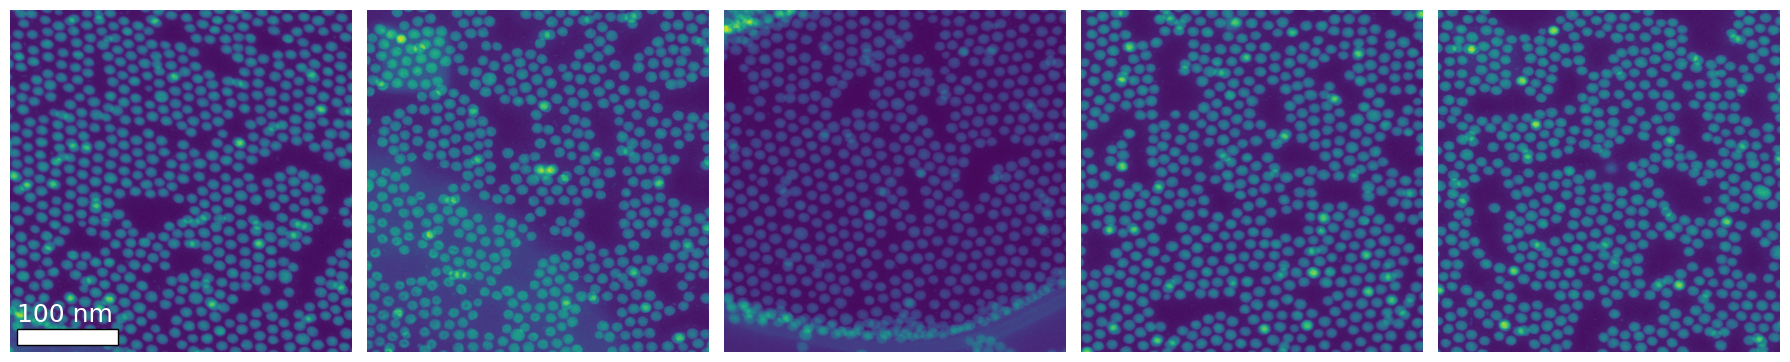

In [3]:
#quickly plotting data

idx = 0
img = img_list[idx]
scale = metadata_list[idx].get('scale')

SCALEBAR_HEIGHT = 50
SCALEBAR_OFFSET = 20

fig,ax=plt.subplots(1,5,figsize=(18,6))
for i,a in zip(img_list,ax.ravel()):
    a.imshow(i.data)
    a.axis('off')
    
#adding scale bar
scalebar_length = 100/scale #100 nm scalebar
scalebar_coords = (SCALEBAR_OFFSET,img.shape[0]-SCALEBAR_OFFSET-SCALEBAR_HEIGHT)

scalebar = Rectangle(scalebar_coords,scalebar_length,SCALEBAR_HEIGHT,
                     facecolor='white',edgecolor='k')
ax[0].add_patch(scalebar)
ax[0].text(SCALEBAR_OFFSET,img.shape[0]-SCALEBAR_OFFSET-SCALEBAR_HEIGHT-SCALEBAR_OFFSET,
           '100 nm',fontsize=18,color='white')

plt.tight_layout()
plt.show()

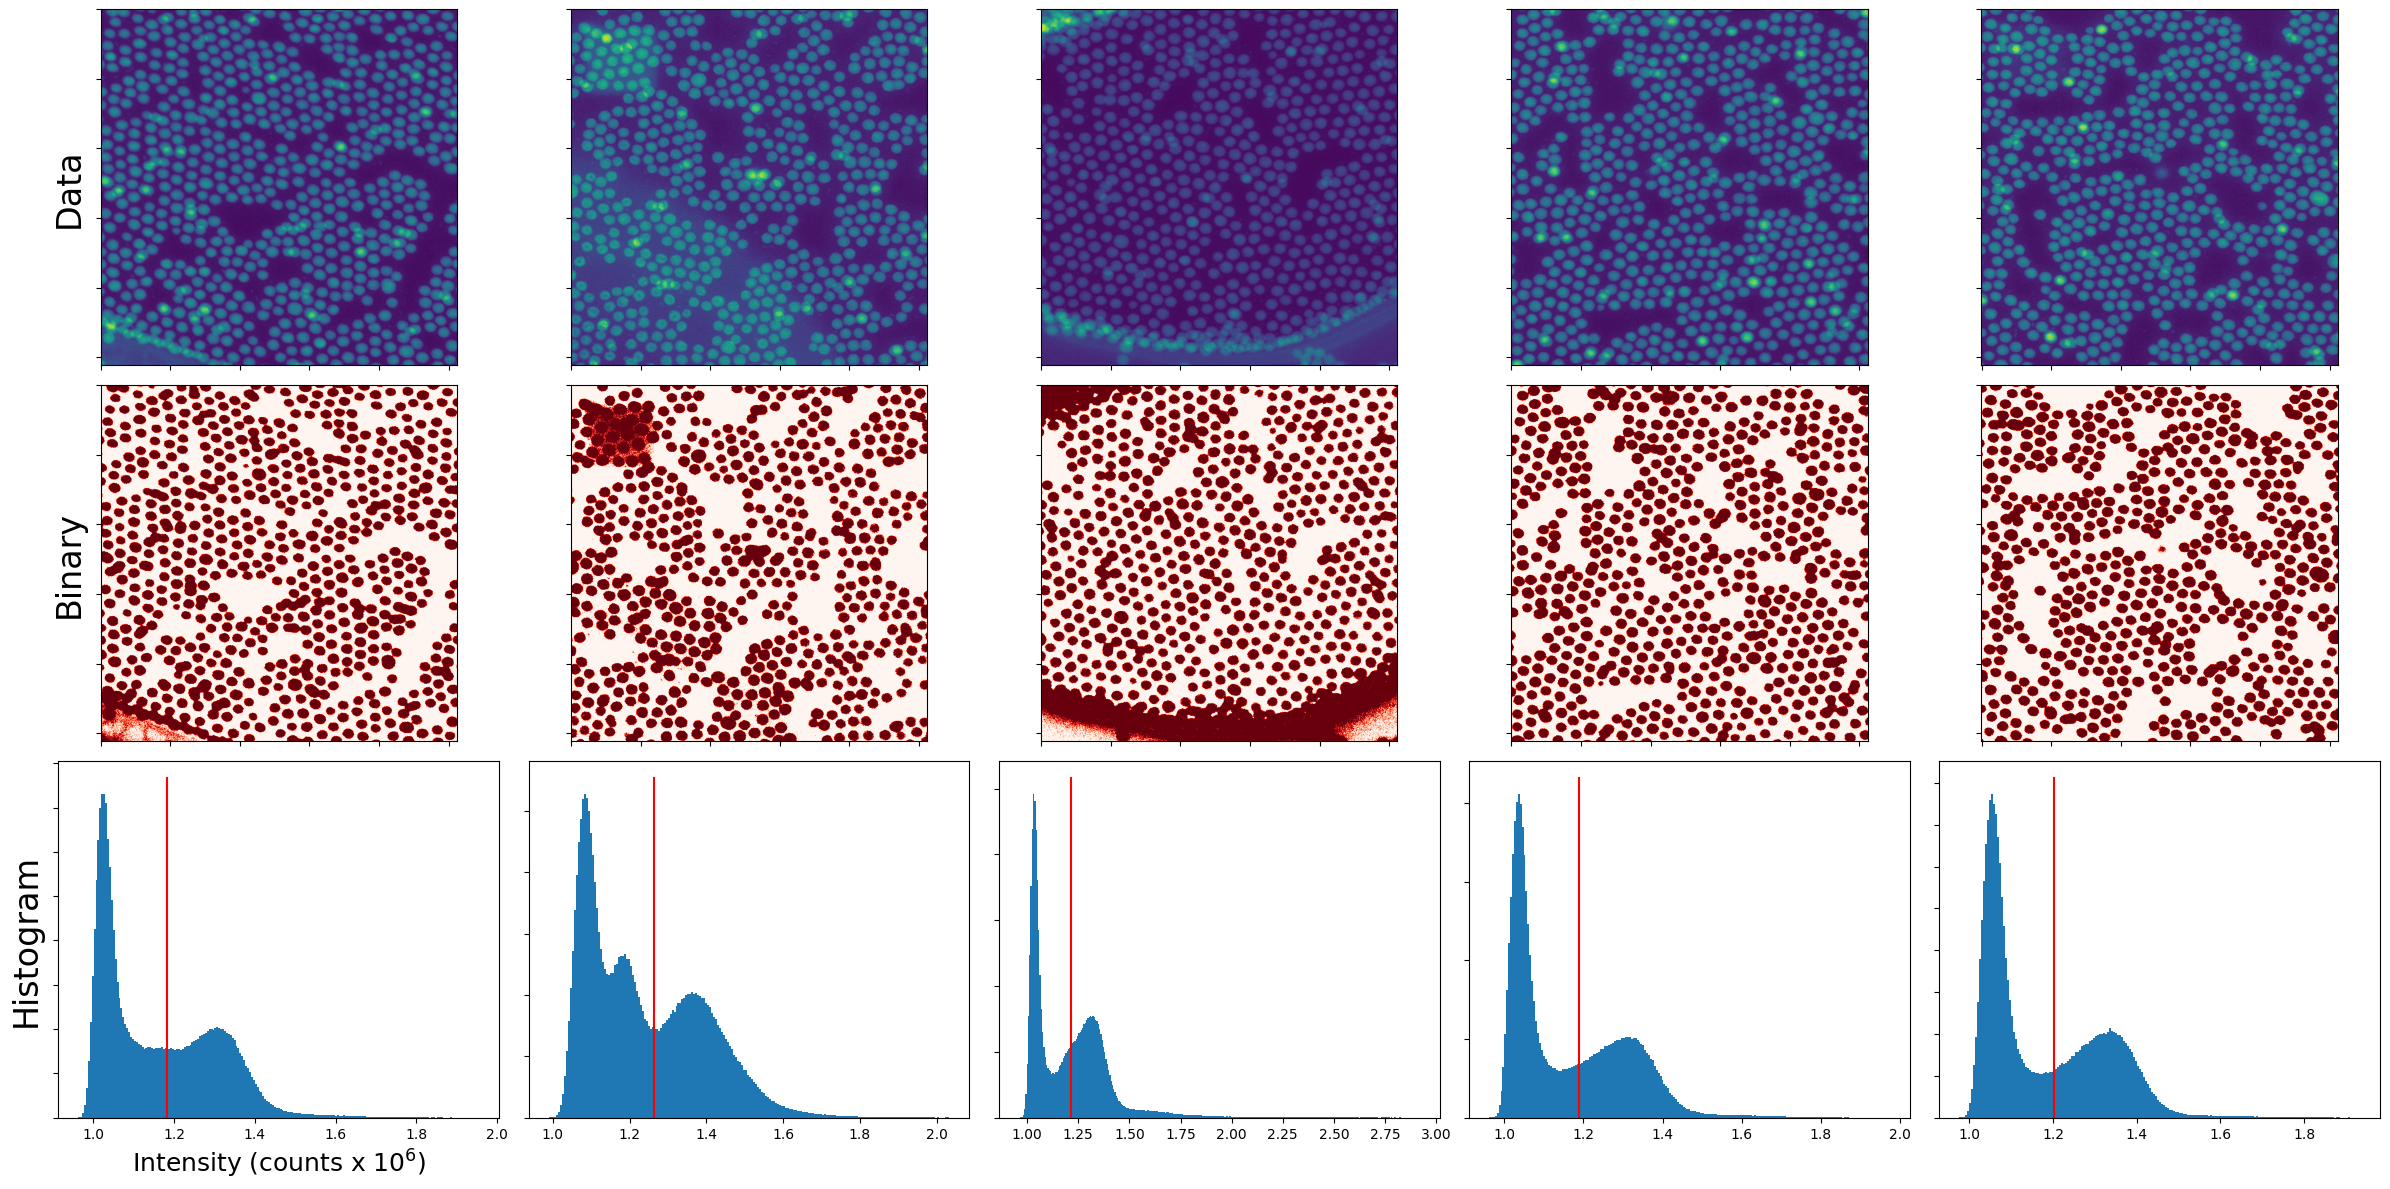

In [4]:
#creating thresholds using otsu method and plotting results
binlist = [] 
fig,ax=plt.subplots(3,5,figsize=(24,12))
for i,a in zip(img_list,ax.T):
    a[0].imshow(i,cmap='viridis') #original data
    a[0].xaxis.set_ticklabels([])
    a[0].yaxis.set_ticklabels([])
    
    t = threshold_otsu(i) #finding threshold value
    binary = i > t #creating binary threshold image
    binlist.append(binary)
    
    a[1].imshow(binary,cmap = 'Reds') #plotting binary image
    a[1].xaxis.set_ticklabels([])
    a[1].yaxis.set_ticklabels([])
    
    a[2].hist(i.ravel()*1e-6,bins='scott') #plotting histogram of data to demonstrate thresholding method
    a[2].plot([t*1e-6,t*1e-6],[0,a[2].get_ylim()[1]],'r') #plotting threshold value as red line
    a[2].yaxis.set_ticklabels([])
    
ax[0,0].set_ylabel('Data',fontsize=24)    
ax[1,0].set_ylabel('Binary',fontsize=24)
ax[2,0].set_ylabel('Histogram',fontsize=24)
ax[2,0].set_xlabel('Intensity (counts x 10$^6$)',fontsize=18)

plt.tight_layout()
plt.show()

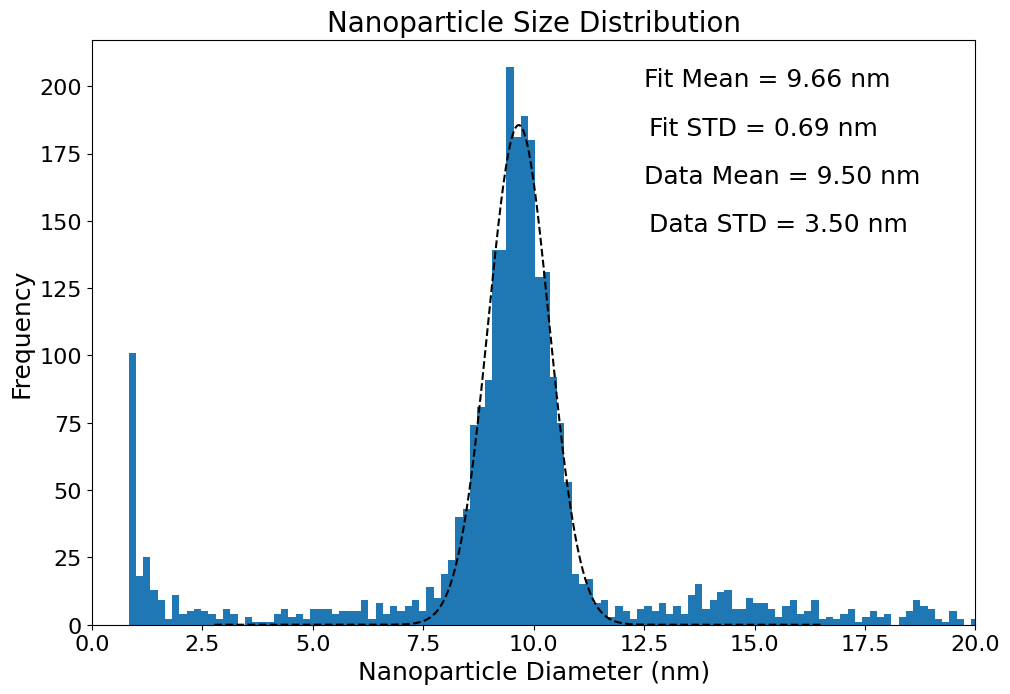

In [5]:
#determining size of each binary connected region

diams = []
def model(x,a,x0,s): #fitting histogram to gaussian
        return a*np.exp(-(x-x0)**2/(2*s**2))

fig_scale = 0.95
fig,ax = plt.subplots(1,1,figsize=(fig_scale*12,fig_scale*8))

#simplest analysis, rejecting small regions with less than 4 pixels and large regions bigger than 5000 pixels
for b in binlist:
    labs = label(b) #this labels all connected regions
    for r in regionprops(labs): #this measures properties of the labeled regions
        if r.area > 4 and r.area < 5000: 
            diams.append(r.equivalent_diameter*scale)

diams = np.array(diams)
bins = np.arange(diams.min(),diams.max()+scale/2,scale/2) #calculating bins, somewhat arbitrary
            
nums,bin_edges,hist = ax.hist(diams,bins=bins)
centers = (bin_edges[:-1]+bin_edges[1:])/2 #finding bin centers for fitting

#estimate starting parameters using data stats
params,cov = curve_fit(model,centers,nums,p0=[nums.max(),diams[nums.argmax()],diams.std()],bounds=[(0,0,0),(np.inf,np.inf,np.inf)])

xx = np.linspace(params[1]-10*params[2],params[1]+10*params[2],500)
ax.plot(xx,model(xx,*params),'--k')
ax.set_xlim(0,20)

ax.set_title('Nanoparticle Size Distribution',fontsize=20)
ax.set_xlabel('Nanoparticle Diameter (nm)',fontsize=18)
ax.set_ylabel('Frequency',fontsize=18)

ax.tick_params(axis='both', which='major', labelsize=16)

ax.text(12.5,200,'Fit Mean = %.2f nm'%params[1],fontsize=18)
ax.text(12.6,182,'Fit STD = %.2f nm'%params[2],fontsize=18)
ax.text(12.5,164,'Data Mean = %.2f nm'%diams.mean(),fontsize=18)
ax.text(12.6,146,'Data STD = %.2f nm'%diams.std(),fontsize=18)

plt.show()

In [ ]:
#making a summary figure for use in manuscript the figure design is mostly manual
#Only using 4 (arbitrarily chosen) images for figure for aesthetic display reasons
fig = plt.figure(figsize=(21,7))

cols = 6
rows = 2

#making grid
ax00 = plt.subplot2grid((rows,cols), (0, 0))
ax01 = plt.subplot2grid((rows,cols), (0, 1))
ax02 = plt.subplot2grid((rows,cols), (0, 2))
ax03 = plt.subplot2grid((rows,cols), (0, 3))
ax10 = plt.subplot2grid((rows,cols), (1, 0))
ax11 = plt.subplot2grid((rows,cols), (1, 1))
ax12 = plt.subplot2grid((rows,cols), (1, 2))
ax13 = plt.subplot2grid((rows,cols), (1, 3))
ax14 = plt.subplot2grid((rows,cols), (0, 4),colspan=2,rowspan=2)

#STEM images
ax00.imshow(img_list[0].data)
ax00.xaxis.set_ticklabels([])
ax00.yaxis.set_ticklabels([])
ax00.xaxis.set_ticks([])
ax00.yaxis.set_ticks([])
ax00.set_ylabel('  STEM \n Images',fontsize=20,rotation=0,labelpad=50)

ax01.imshow(img_list[1].data)
ax01.axis('off')

ax02.imshow(img_list[3].data)
ax02.axis('off')

ax03.imshow(img_list[4].data)
ax03.axis('off')

#Binary images
ax10.imshow(binlist[0].data,cmap='Reds')
ax10.xaxis.set_ticklabels([])
ax10.yaxis.set_ticklabels([])
ax10.xaxis.set_ticks([])
ax10.yaxis.set_ticks([])
ax10.set_ylabel('  Binary \n Images',fontsize=20,rotation=0,labelpad=50)

ax11.imshow(binlist[1].data,cmap='Reds')
ax11.axis('off')

ax12.imshow(binlist[3].data,cmap='Reds')
ax12.axis('off')

ax13.imshow(binlist[4].data,cmap='Reds')
ax13.axis('off')

#Histogram and normal curve fit
ax14.hist(diams,bins=bins)
ax14.set_xlim(1,20)

xx = np.linspace(1,20,300)
ax14.plot(xx,model(xx,*params),'--k')

ax14.set_title('Nanoparticle Size Distribution',fontsize=20)
ax14.set_xlabel('Nanoparticle Diameter (nm)',fontsize=18)

ax14.tick_params(axis='both', which='major', labelsize=16)

ax14.text(12.5,205,'Mean = %.2f nm'%params[1],fontsize=18)
ax14.text(12.6,192,'STD = %.2f nm'%params[2],fontsize=18)

size_pix = 100/scale
rect = Rectangle((20,1024-20-50),size_pix,50,facecolor='white',edgecolor='k')

ax00.add_patch(rect)
ax00.text(10,1024-20-50-20,'100 nm',fontsize=14,color='white')

ax00.yaxis.set_label_coords(-0.28,0.4)
ax10.yaxis.set_label_coords(-0.28,0.4)

ax00.text(-280,10,'(a)',fontsize=32,color='k')
ax10.text(-280,10,'(b)',fontsize=32,color='k')
ax14.text(1.2,205,'(c)',fontsize=32,color='k')

plt.tight_layout()
#plt.savefig('Nanoparticle_Size.pdf',dpi=300)
plt.show()